### Getting the Dataset

This example uses the [Data Set 1][bcicomp3ds1] from the BCI Competition 3. After downloading and copying it into a directory called `data` next to this script, you should be able to follow this example.

[bcicomp3ds1]: http://www.bbci.de/competition/iii/#data_set_i


In [1]:
from __future__ import division

import numpy as np
import scipy as sp
from scipy.io import loadmat
import matplotlib as mpl
from wyrm import processing as proc
from wyrm.types import Data
from wyrm import plot
from matplotlib import pyplot as plt

from os import path

DEBUG:matplotlib:CACHEDIR=/home/nahuel/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/nahuel/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
#Se carga data txt Class-Channel x Time (17792 x 3000)
data_train_txt = np.loadtxt('/home/nahuel/Documents/TESIS/DATA/Competencia BCI/III/Dataset_I/txt/Competition_train_cnt.txt')

#Convertimos data_txt en una matriz de 3 dimensiones Class x Channel x Time (278 x 64 x 3000)
data_train_txt.shape = (278, 64, 3000)
#Modificamos el orden de las dimensiones como Class x Time x Channel (278 x 3000 x 64)
data_train_txt = data_train_txt.swapaxes(-1, -2)


In [3]:
#Se carga 278 etiquetas de Class del conjunto de train
data_lab_txt = np.loadtxt('/home/nahuel/Documents/TESIS/DATA/Competencia BCI/III/Dataset_I/txt/Competition_train_lab.txt')

#Convierte a enteros y si es necesario devuelve un vector de una dimension
data_lab_txt = data_lab_txt.astype('int').ravel()
#Convertimos los -1 a 0
data_lab_txt[data_lab_txt == -1] = 0


In [4]:
#Convertimos a wyrm Data - Set Train
#Cargamos data training
data = data_train_txt
labels = data_lab_txt

#Creamos axes con enumerados de la misma longitud que data Class x Time x Channel
axes = [np.arange(i) for i in data.shape]
#Se completa la dimension Class con labels
axes[0] = labels
#Se convierte a str la dimension Channel
#axes[2] = [str(i) for i in range(data.shape[2])]
axes[2] = ['PPO4','CP4','PCP1','F5','C3','C4','O1','PPO2','FFC2','FAF5','PO1','TP10','FAF1','FFC6','FFC1','PO10','O10','C1','Cz','F2','CFC1','CCP2','F4','PO9','CFC6','TP7','FC6','AF8','Fz','AF4','PCP9','F6','FT10','FAF6','PO5','O2','OPO2','AF5','C2','P4','TP9','PCP7','FT8','A2','PO6','FC3','PPO1','CCP8','OPO1','AFp2','OI2','OI1','FCz','CCP6','CCP1','CPz','POz','FFC3','FFC7','FC2','F1','FT9','P2','P10']

names = ['Class', 'Time', 'Channel']
units = ['#', 'ms', '#']
dat_train = Data(data=data, axes=axes, names=names, units=units)
dat_train.fs = 1000
dat_train.class_names = ['pinky', 'tongue']


In [5]:
#Se carga data txt Epoch-Channel x Time (6400 x 3000)
data_test_txt = np.loadtxt('/home/nahuel/Documents/TESIS/DATA/Competencia BCI/III/Dataset_I/txt/Competition_test_cnt.txt')
#Convertimos data_txt en una matriz de 3 dimensiones Epoch x Channel x Time (100 x 64 x 3000)
data_test_txt.shape = (100, 64, 3000)
#Modificamos el orden de las dimensiones como Epoch x Time x Channel (100 x 3000 x 64)
data_test_txt = data_test_txt.swapaxes(-1, -2)

In [6]:
#Convertimos a wyrm Data - Set Test
#Cargamos data test
data = data_test_txt

#Creamos axes con enumerados de la misma longitud que data Class x Time x Channel
axes = [np.arange(i) for i in data.shape]
#Se convierte a str la dimension Channel
axes[2] = [str(i) for i in range(data.shape[2])]
names = ['Epoch', 'Time', 'Channel']
units = ['#', 'ms', '#']
dat_test = Data(data=data, axes=axes, names=names, units=units)
dat_test.fs = 1000


In [7]:
def plot_csp_pattern(a):
    # get symmetric min/max values for the color bar from first and last column of the pattern
    maxv = np.max(np.abs(a[:, [0, -1]]))
    minv = -maxv
    
    im_args = {'interpolation' : 'None', 
           'vmin' : minv, 
           'vmax' : maxv
           }

    # plot
    ax1 = plt.subplot2grid((1,11), (0,0), colspan=5)
    ax2 = plt.subplot2grid((1,11), (0,5), colspan=5)
    ax3 = plt.subplot2grid((1,11), (0,10))

    ax1.imshow(a[:, 0].reshape(8, 8), **im_args)
    ax1.set_title('Pinky')

    ax = ax2.imshow(a[:, -1].reshape(8, 8), **im_args)
    ax2.set_title('Tongue')

    plt.colorbar(ax, cax=ax3)
    plt.tight_layout()

In [8]:
def filtros(data):
    dat = data.copy()
    
    #Mitad de la frecuencia
    fs_n = dat.fs / 2
    
    #Se aplica filtros
    b, a = proc.signal.butter(5, [13 / fs_n], btype='low')   
    dat = proc.filtfilt(dat, b, a)
    
    b, a = proc.signal.butter(5, [9 / fs_n], btype='high')
    dat = proc.filtfilt(dat, b, a)
    return dat
    

In [9]:
def preprocess(data, filt=None):
    #Se aplican los filtros
    dat=filtros(data)
    
    #Se toma una muestra de 50 cada 1000 (fs_n = 1000) (278 x 150 x 64)
    dat = proc.subsample(dat, 50)
        
    if filt is None:
        #Calcula el patrón espacial común (CSP) para dos clases.
        filt, pattern, _ = proc.calculate_csp(dat)
        #Grafica csp_pattern
        plot_csp_pattern(pattern)
        
    #Aplica el CSP
    dat = proc.apply_csp(dat, filt)
    #print(filt[0])
    dat = proc.variance(dat)
    dat = proc.logarithm(dat)
    return dat, filt

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff886489588>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff886489588>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSize

DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstScreen' (KacstScreen.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Oriya' (NotoSansOriya-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif' (NotoSerif-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Shavian' (NotoSansShavian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSer

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstPoster' (KacstPoster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Purisa' (Purisa.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Vemana2000' (vemana2000.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sinhala UI' (NotoSansSinhalaUI-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Telugu UI' (NotoSansTeluguUI-Bold.ttf) normal no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_Main' (MathJax_Main-Italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_Typewriter' (MathJax_Typewriter-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfon

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gurmukhi UI' (NotoSansGurmukhiUI-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lycian' (NotoSansLycian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Navilu' (Navilu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Rejang' (NotoSansRejang-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSa

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'NanumGothic' (NanumGothic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_Main' (MathJax_Main-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Vai' (NotoSansVai-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tai Viet' (NotoSansTaiViet-Regular.ttf) normal normal 400 norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Canadian Aboriginal' (NotoSansCanadianAboriginal-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstDigital' (KacstDigital.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_Caligraphic' (MathJax_Caligraphic-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Loma' (Loma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'NanumGothic' (NanumGothicBold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Khmer

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Pothana2000' (Pothana2000.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'padmaa' (padmaa.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Buhid' (NotoSansBuhid-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Kannada' (Lohit-Kannada.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Bold.otf) normal normal bold normal>) = 10.335
D

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Adlam' (NotoSansAdlam-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nakula' (nakula.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_Fraktur' (MathJax_Fraktur-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer OS' (KhmerOS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Deseret' (NotoSansDeseret-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gujarati' (NotoSansGujarati-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-M.ttf) normal normal mediu

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Naskh Arabic UI' (NotoNaskhArabicUI-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Loma' (Loma-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSans' (FreeSans.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif' (NotoSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_Math' (MathJax_Math-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-B.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'WenQuanYi Micro Hei' (

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rekha' (Rekha.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif' (NotoSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstLetter' (KacstLetter.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSans' (FreeSansBold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Gujarati' (NotoSerifGujarati-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:ma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Laksaman' (Laksaman-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Laksaman' (Laksaman.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'NanumSquare' (NanumSquareR.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal light normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Hanunoo' (NotoSansHanunoo-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstOne' (KacstOne.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Naskh Arabic' (NotoNaskhArabic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk' (Padauk-Bold.ttf) normal 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_Size3' (MathJax_Size3-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Egyptian Hieroglyphs' (NotoSansEgyptianHieroglyphs-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans' (NotoSans-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk Book' (PadaukBook-Regular.ttf) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(

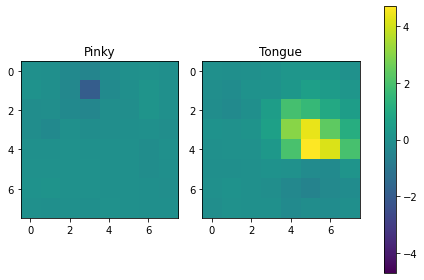

In [10]:
#Se calcula el vector de caracteristicas para los conjuntos de train y test
fv_train, filt = preprocess(dat_train)
fv_test, _ = preprocess(dat_test, filt)

In [11]:
#dat_new = proc.remove_channels(dat_train, ['PPO4','CP4'])
#proc.select_channels(dat_train, ['PPO4','CP4'])

In [12]:
#Se carga 100 etiquetas TRUE LABELS
TRUE_LABELS = '/home/nahuel/Documents/TESIS/DATA/Competencia BCI/III/Dataset_I/txt/true_labels.txt'

true_labels = np.loadtxt(TRUE_LABELS).astype('int')
#Convertimos los -1 a 0
true_labels[true_labels == -1] = 0


In [13]:
#Entrenamiento con LDA clasificador.
cfy = proc.lda_train(fv_train)

#Aplicar vector de características al clasificador LDA.
result = proc.lda_apply(fv_test, cfy)

#Normaliza resultados
#Si es > 0 = 1 sino -1
result = (np.sign(result)).astype('int')
#Convertimos los -1 a 0
result[result == -1] = 0

#Se compara los resultados del modelo contra los TRUE LABELS
print ('LDA Accuracy %.2f%%' % ((result == true_labels).sum() / len(result)) ) 


LDA Accuracy 0.94%


In [14]:
plt.show()